Consideramos el modelo:

$$\mu = 25 - 5 \log_{10}(H_0/100) + 5\log_{10}(D_L/Mpc)$$

Donde $D_L$ tiene como solución aproximada:

$$D_L = {c \over H_0} (1 + z)[\eta(1, \Omega_m) - \eta(1/(1+z), \Omega_m)]$$

Siendo:

$$\eta(a,\Omega_m) = 2\sqrt{s^3+1}[a^{-4} - 0.1540sa^{-3} + 0.4304s^2a^{-2} + 0.19097s^3a^{-1} + 0.066941s^4]^{-1/8}$$

Que a su vez:

$$s^3 = (1- \Omega_m)/\Omega_m$$

Podemos hacer una estimación de los parámetros $H_0$ y $\Omega_m$ que mejor ajustan los datos de nuestro modelo utilizando la función Likelihood:

$$\mathcal{L} \propto \prod_i^n {1 \over 2\pi \sigma_i^2}exp \left( - \frac{(x_i-\mu)^2}{2\sigma_i^2}\right )$$

o bien:

$$-ln(\mathcal{L}) \propto {1 \over 2} \sum_i^n \left( \frac{(y_i - \lambda(x_i, \vec{\theta}))^2}{\sigma_i^2} \right)$$

En este caso, $y_i$ son los datos de $\mu$; $x_i$, los datos para $z$; y los parámetros $\vec{\theta}$ son $\Omega_m$ y $H_0$

Trataremos de maximizar esta función utilizando el algoritmo de Metrópolis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from random import random, gauss

Text(0.5,1,'Datos a ajustar')

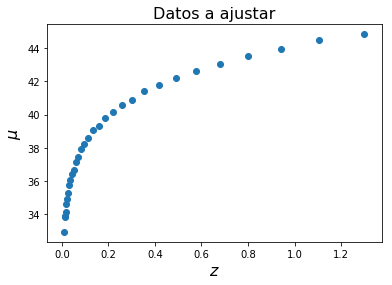

In [2]:
#Importamos los datos de z y mu
datos = np.loadtxt('JLA_SN/jla_mub.txt', usecols = (0,1), skiprows = 1)
z = datos[:, 0]
mu = datos[:, 1]

#Estos datos son los que queremos ajustar con el algoritmo Metropolis
plt.scatter(z, mu)
plt.xlabel('$z$', fontsize = 16)
plt.ylabel('$\mu$', fontsize = 16)
plt.title('Datos a ajustar', fontsize = 16)

Como los elementos de la matriz de covarianza están en una lista y solamente nos interesa la varianza, e decir la diagonal de esa matriz, necesitamos saber qué elementos de esa lista son. 

Para una matriz cuadrada de dimensión $n$, los elementos de la diagonal son $i(n+1)$, siendo $i$ el $i$-ésimo elemento de la diagonal.

In [3]:
#Importamos los datos de la matriz de covarianza
datos_cov = np.loadtxt('JLA_SN/jla_mub_covmatrix.dat', skiprows = 1)

#Solamente nos interesa la varianza, es decir, los elementos de la diagonal de la matriz de covarianza
varianza = np.array([])

for i in range(31):
    varianza = np.append(varianza, datos_cov[i*(31+1)])


Definimos las funciones

In [4]:
def s(parametros):
    Om = parametros
    result = pow((1 - Om)/Om, 1./3.)
    return result

In [5]:
def eta(a, parametros):
    Om = parametros
    coef = [-0.1540, 0.4304, 0.19097, 0.066941]
    S = s(Om)
    poli = 1/a**4 + coef[0]*S/a**3 + coef[1]*S**2/a**2 + coef[2]*S**3/a + coef[3]*S**4
    
    return 2*np.sqrt(S**3 + 1)/pow(poli,1./8.)

In [6]:
def DL(z,parametros):
    H0, Om = parametros
    c = 299792.5 #km/s
    
    result = c/H0 * (1 + z) * (eta(1, Om) - eta(1/(1 + z), Om))
    return result


In [7]:
def Mu(z, parametros):
    H0, Om = parametros
    result = 25 - 5*math.log10(H0/100) + 5*math.log10(DL(z, parametros))
    
    return result

Definimos el negativo del logaritmo natural del Likelihood

In [8]:
def ln_L(mu, z, parametros, varianza):
    suma = 0
    for i in range(len(mu)):
        suma += (mu[i] - Mu(z[i], parametros))**2/varianza[i]
    return 0.5*suma

In [9]:
def Metropolis(parametros, mu, z, varianza, pasos):
    old_H0, old_Om = parametros
    
    #Lista para guardar los parametros
    param_list = [0 for i in range(pasos)]
    param_list[0] = parametros
    
    #Calculamos el likeliood (logaritmo) con esos valores iniciales
    old_L = ln_L(mu, z, parametros ,varianza)
    
    i = 1
    while i < pasos:
        new_H0 = gauss(old_H0, 0.2)
        new_Om = gauss(old_Om, 0.01)
        parametros = [new_H0, new_Om]
        
        #Si Omega m es negativvo o mayor a uno, lo rechazamos
        if new_Om < 0 or new_Om > 1:
            new_Om = old_Om
            continue
    
    #Calculamos el nuevo Likelihood (logaritmo) para compararlo con el anterior
        new_L = ln_L(mu, z, parametros, varianza)
    
    #Maximixar el Likelihood es equivalente a minimizar el negativo de su logaritmo
        if new_L < old_L:
            old_L = new_L
            old_Om = new_Om
            old_H0 = new_H0
            param_list[i] = parametros
            i += 1
        
    #Como Likelihood es una probabilidad, tenemos que normalizar su logaritmo y compararlo con un valor aleatorio
        elif old_L/new_L < random():
            old_L = new_L
            old_Om = new_Om
            old_H0 = new_H0
            param_list[i] = parametros
            i += 1
            
    param_list = np.array(param_list).T
    return param_list

In [17]:
#parametros = [H0, Om]
parametros1 = [53, 0.4]
parametros2 = [65, 0.2]
parametros3 = [90, 0.9]

pasos = 10000

#Caculamos varias cadenas
param_list1 = Metropolis(parametros1, mu, z, varianza, pasos)
param_list2 = Metropolis(parametros2, mu, z, varianza, pasos)
param_list3 = Metropolis(parametros3, mu, z, varianza, pasos)

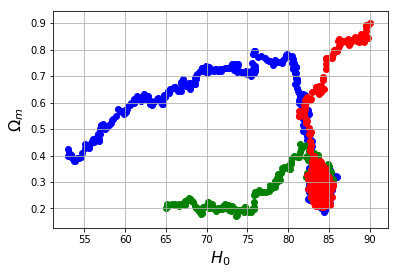

In [18]:
#Graficamos todas las cadenas
plt.scatter(param_list1[0], param_list1[1], c='b')
plt.scatter(param_list2[0], param_list2[1], c='g')
plt.scatter(param_list3[0], param_list3[1], c='r')
plt.xlabel('$H_0$', fontsize = 16)
plt.ylabel('$\Omega_m$', fontsize = 16)
plt.grid(True)

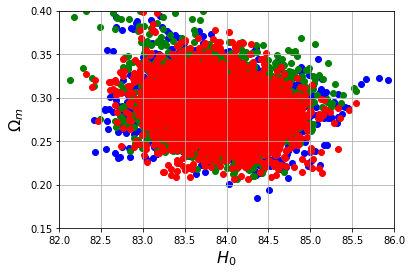

In [19]:
hmin, hmax = 82, 86
omin, omax = 0.15, 0.4

#Hacemos un zoom en la zona de convergencia
plt.scatter(param_list1[0], param_list1[1], c='b')
plt.scatter(param_list2[0], param_list2[1], c='g')
plt.scatter(param_list3[0], param_list3[1], c='r')
plt.axis([hmin, hmax, omin, omax])
plt.xlabel('$H_0$', fontsize = 16)
plt.ylabel('$\Omega_m$', fontsize = 16)
plt.grid(True)

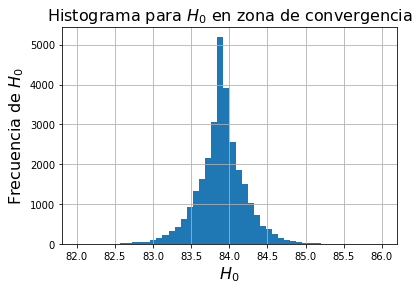

In [20]:
#Hacemos una lista en la zona de convergencia para H0
H0_gauss = []
h1, h2, h3 = param_list1[0], param_list2[0], param_list3[0]
#Excluimos datos fuera de la zona de convergencia
for i in range(len(h1)):
    if h1[i] > hmin and h1[i] < hmax:
        H0_gauss.append(h1[i])
    if h2[i] > hmin and h2[i] < hmax:
        H0_gauss.append(h2[i])
    if h3[i] > hmin and h3[i] < hmax:
        H0_gauss.append(h3[i])
#Histograma de H0
n, bins, patches = plt.hist(H0_gauss, bins = 50)
plt.xlabel('$H_0$', fontsize = 16)
plt.ylabel('Frecuencia de $H_0$', fontsize = 16)
plt.title('Histograma para $H_0$ en zona de convergencia', fontsize = 16)
plt.grid()

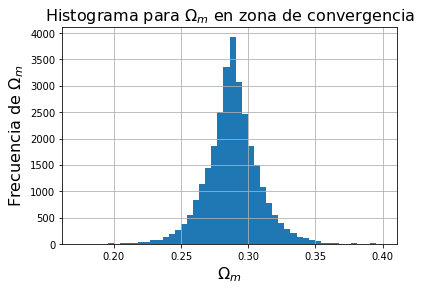

In [21]:
#Hacemos una lista para Omega m en la zona de convergencia
Om_gauss = []
o1, o2, o3 = param_list1[1], param_list2[1], param_list3[1]
#Excluimos valores que no esten en esa region
for i in range(len(o1)):
    if o1[i] > omin and o1[i] < omax:
        Om_gauss.append(o1[i])
    if o2[i] > omin and o2[i] < omax:
        Om_gauss.append(o2[i])
    if o3[i] > omin and o3[i] < omax:
        Om_gauss.append(o3[i])
        
#Hacemos el histograma de esa zona
n, bins, patches = plt.hist(Om_gauss, bins = 50)
plt.xlabel('$\Omega_m$', fontsize = 16)
plt.ylabel('Frecuencia de $\Omega_m$', fontsize = 16)
plt.title('Histograma para $\Omega_m$ en zona de convergencia', fontsize = 16)
plt.grid()

Text(0.5,1,'Mejor ajuste')

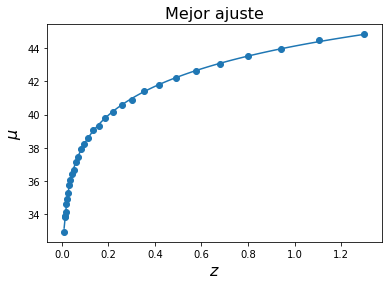

In [26]:
h0, om = 83.8, 0.28    #Valores medios de H0 y Om que mejor ajustan los datos
p = [h0, om]
zeta = np.linspace(0.01,1.3, 100)
modelo = np.array([Mu(i, p) for i in zeta])

plt.scatter(z, mu)
plt.plot(zeta, modelo)
plt.xlabel('$z$', fontsize = 16)
plt.ylabel('$\mu$', fontsize = 16)
plt.title('Mejor ajuste', fontsize = 16)